In [34]:
import numpy as np
import json, os, h5py

from FLKutils2 import plot_data, return_best_chi2dof, plot_ref_data
from scipy.special import logsumexp
from scipy.stats import norm

from matplotlib import pyplot as plt

## nplm-fuse

In [61]:
ref_folder = "/home/marcol/multiple-testing-nplm/output_5d/Ntoys1000_NR100000_NB20000_cut60_null"
data_folder = "/home/marcol/multiple-testing-nplm/output_5d/Ntoys300_NR100000_NB20000_NS20_Z300_cut60"
#data_folder = "/home/marcol/multiple-testing-nplm/output_5d/Ntoys300_NR100000_NB20000_NS41_EFT_cut60"

In [62]:
ref = np.load(ref_folder+"/t_array.npy")
data = np.load(data_folder+"/t_array.npy")

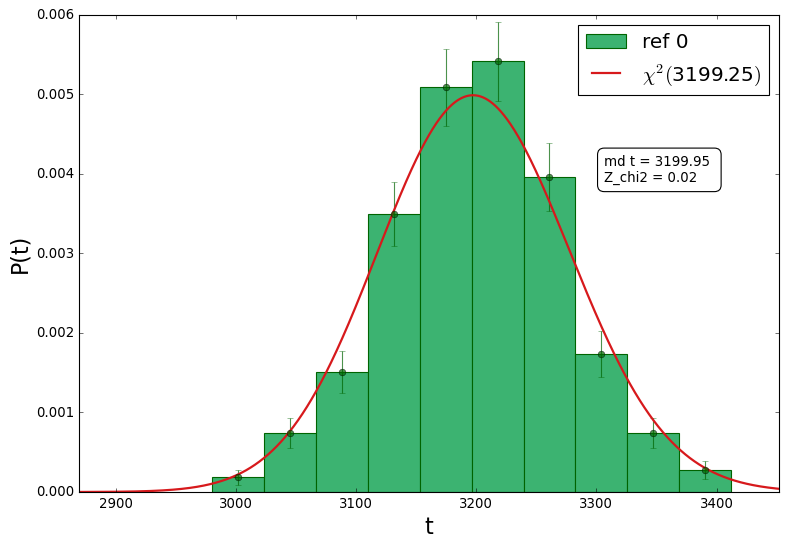

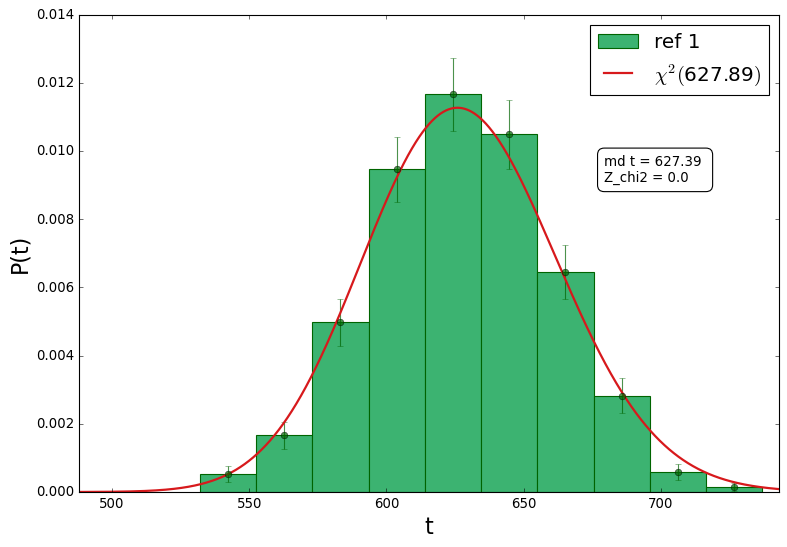

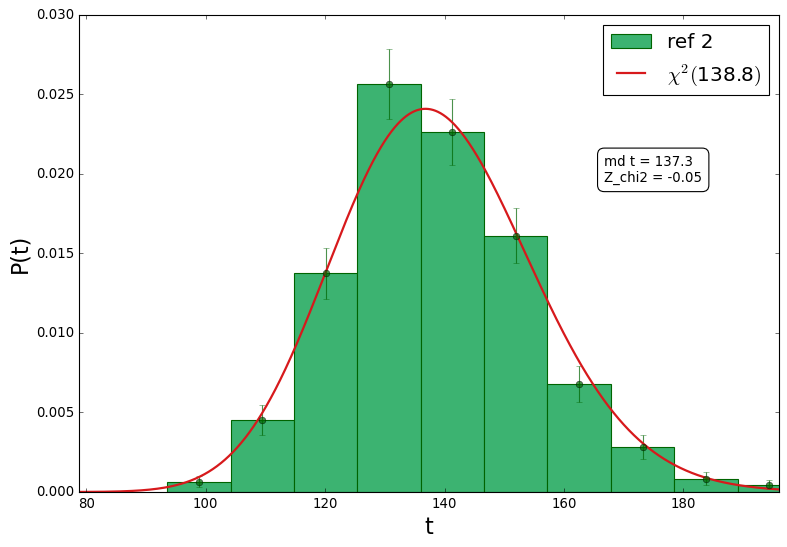

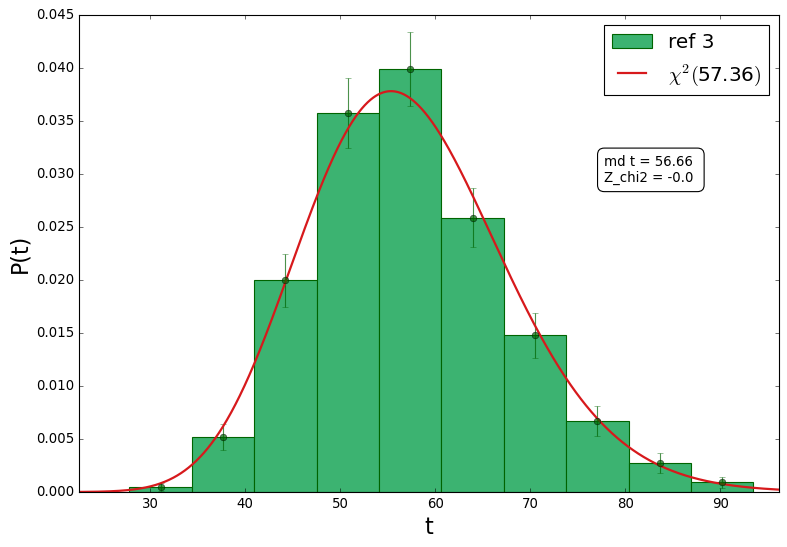

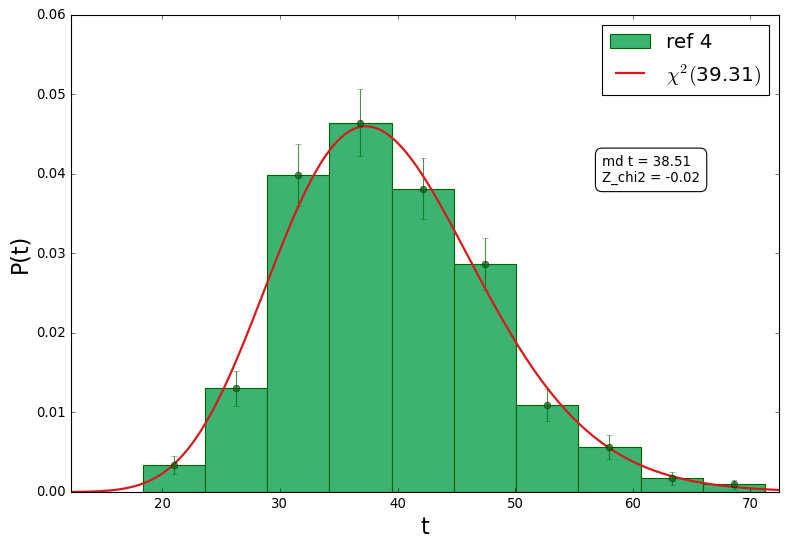

In [63]:
for i in np.arange(ref.shape[1]):
    plot_data(ref[:,i], label=f'ref {i}', dof=round(return_best_chi2dof(ref[:,i])[0],2))

In [64]:
def emp_p_value(ref,data,right=True):
    #for idx,el in enumerate(t):
    #    p[idx] = np.mean(ref>=t)
    if right : p = np.array([np.mean(ref>=t) for t in data])
    else : p = np.array([np.mean(ref<=t) for t in data])
    p[p==0] = 1/len(ref)
    return p

def p_to_z(pvals):
    return norm.ppf(1 - pvals)

def Zscore(ref,data):
    return p_to_z(emp_p_value(ref,data))

def power(t_ref,t_data, alpha=np.array([0.309,0.159,0.06681,0.0228,0.00620]), right=True):
    # alpha values approx corresponding to Z=.5,1,2,2.5
    if right: quantiles = np.quantile(t_ref,1-alpha)
    else: quantiles = np.quantile(t_ref,alpha)
    return p_to_z(alpha), emp_p_value(t_data,quantiles, right=right)
    

def fusion(x,T):
    return T * logsumexp(1/T*x, axis=1, b=1/x.shape[1])

def fused_t(ref,data,T):
    fused_ref = fusion(ref,T)
    fused_data = fusion(data,T)

    return emp_p_value(fused_ref,fused_data)

def bootstrap_pn(pn,seed=None):
    rnd = np.random.default_rng(seed=seed)
    return rnd.choice(pn,size=len(pn))

def bootstrap_pval(pn,t,seed=None):

    p = np.mean(bootstrap_pn(pn,seed=seed)<=t)

    return p if p > 0 else 1/(len(pn)+1)

    return 

def min_p(ref,data):
    # ref: nxd numpy array
    # data: mxd numpy array
    p_ref = np.zeros_like(ref)
    p_data = np.zeros_like(data)

    for idx, col in enumerate(np.transpose(ref)):
        p_ref[:,idx] = np.transpose([bootstrap_pval(np.delete(col,idx),el) for el in col])

    for idx, col in enumerate(np.transpose(data)):
        p=emp_p_value(np.transpose(ref)[idx],col)
        p_data[:,idx] = np.transpose(p)

    p_ref[p_ref == 0] = 1/ref.shape[0]
    p_data[p_data == 0] = 1/ref.shape[0]


    return -np.log(np.min(p_ref,axis=1)), -np.log(np.min(p_data,axis=1))

def fused_p(ref,data,T=1):
    # ref: n_refxd numpy array
    # data: n_dataxd numpy array
    p_ref = np.zeros_like(ref)
    p_data = np.zeros_like(data)

    # empirical p-values for reference toys with a bootstrap approach
    for idx, col in enumerate(np.transpose(ref)):
        p_ref[:,idx] = np.transpose([bootstrap_pval(np.delete(col,idx),el) for el in col])

    # empirical p-values of data
    for idx, col in enumerate(np.transpose(data)):
        p=emp_p_value(np.transpose(ref)[idx],col)
        p_data[:,idx] = np.transpose(p)

    p_ref[p_ref == 0] = 1/ref.shape[0]
    p_data[p_data == 0] = 1/ref.shape[0]

    #return np.min(p_ref,axis=1), np.min(p_data,axis=1)
    return -np.log(-T * logsumexp(-1/T*p_ref, axis=1, b=1/p_ref.shape[1])), -np.log(-T * logsumexp(-1/T*p_data, axis=1, b=1/p_data.shape[1]))


In [65]:
for i in range(ref.shape[1]):
    print(np.median(Zscore(ref[:,i],data[:,i])))

0.06647462635690143
0.4635088446429859
0.9423763325979504
0.8815933719404354
0.8203841979193605


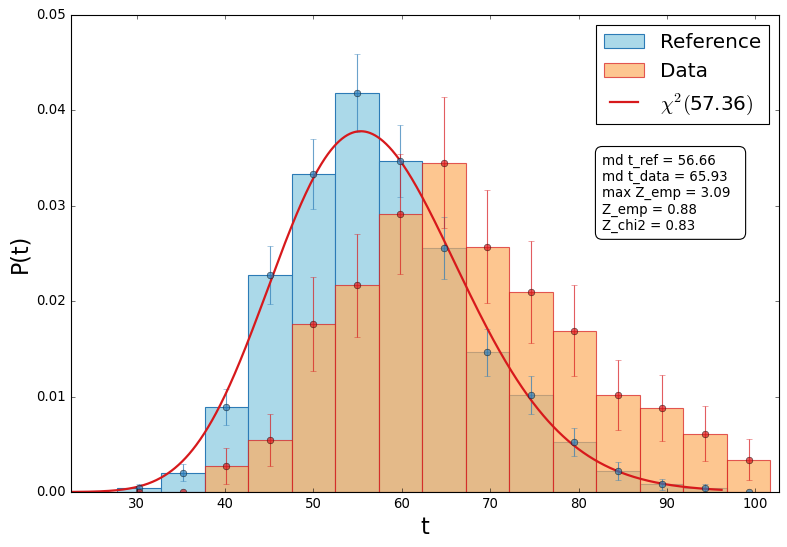

In [66]:
plot_ref_data(ref[:,-2],data[:,-2],bins=15,dof=round(return_best_chi2dof(ref[:10000,-2])[0],2))

In [67]:
for T in [0.001, 1, 10, 1000, 1e5, 1e10]:
    print(np.median(p_to_z((fused_t(ref,data,T)))))

0.06647462635690143
0.06647462635690143
0.06647462635690143
0.12313524773483638
0.4887768985923251
0.5043740297823269


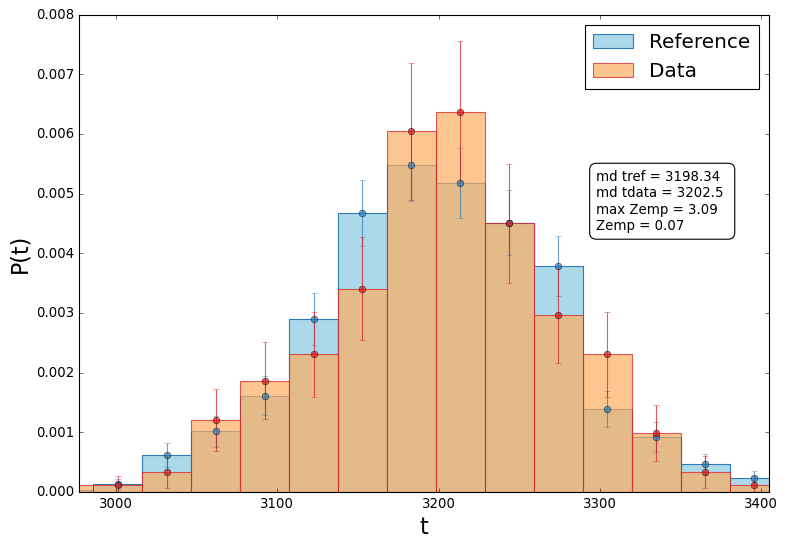

In [68]:
plot_ref_data(fusion(ref,1),fusion(data,1),bins=15)

In [69]:
pmin_ref, pmin_data =  min_p(ref,data)

In [70]:
np.abs(np.median(Zscore(pmin_ref,pmin_data)))

0.7755749428188844

In [71]:
pvals_min_p_ref = []
for idx, el in enumerate(np.transpose(pmin_ref)):
        pvals_min_p_ref.append(bootstrap_pval(np.delete(pmin_ref,idx),el))
#pvals_ref_min = [bootstrap_pval(np.delete(col,idx),el) for el in col]
        
pvals_min_p_data = emp_p_value(pmin_ref,pmin_data)

In [72]:
np.max(pvals_min_p_ref)

1.0

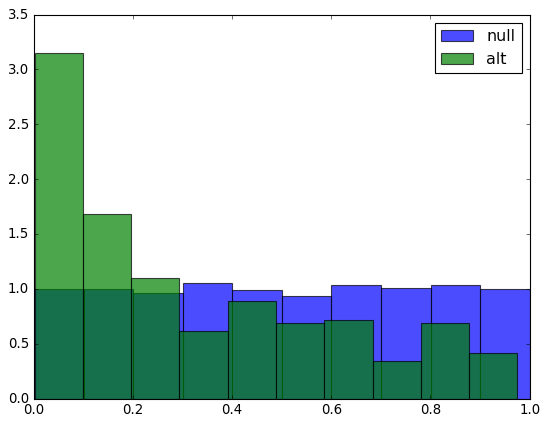

In [73]:
plt.hist(pvals_min_p_ref,bins=10,density=True, alpha=0.7,  label='null')
plt.hist(pvals_min_p_data,bins=10,density=True, alpha=0.7, label='alt')
plt.legend(loc=0)
plt.show()

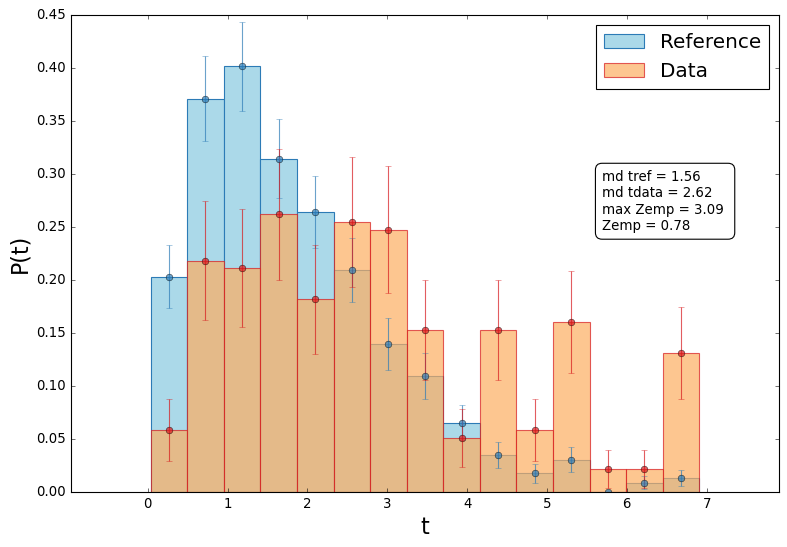

In [74]:
plot_ref_data(pmin_ref,pmin_data,bins=15)

In [75]:
for T in [1e-3, 0.1, 1, 100, 1000]:
    fused_p_ref, fused_p_data = fused_p(ref,data,T)
    print(np.abs(np.median(Zscore(fused_p_ref,fused_p_data))))

0.7755749428188844
0.9096782077036077
0.9078735752879183
0.843409884427482
0.834503995218622


In [76]:
pvals_fused_p_ref = []
for idx, el in enumerate(np.transpose(fused_p_ref)):
        pvals_fused_p_ref.append(bootstrap_pval(np.delete(fused_p_ref,idx),el))
pvals_fused_p_ref = np.array(pvals_fused_p_ref)
pvals_fused_p_ref[pvals_fused_p_ref==0.]=0.001
pvals_fused_p_ref = -np.log(pvals_fused_p_ref)

In [77]:
np.count_nonzero(pvals_fused_p_ref)

999

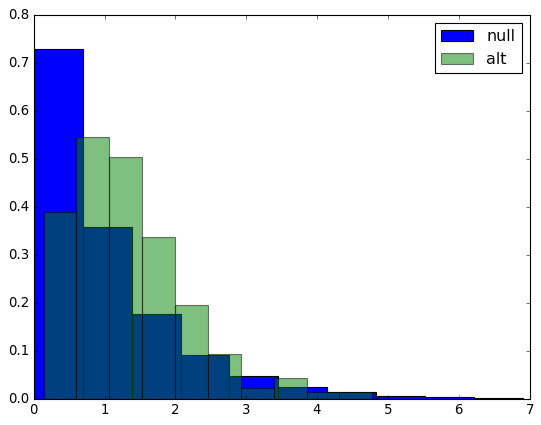

In [78]:
plt.hist(pvals_fused_p_ref,bins=10,density=True, label='null')
plt.hist(fused_p_data,bins=10,density=True, alpha=0.5, label='alt')
plt.legend(loc=0)
plt.show()

In [79]:
fused_p_ref, fused_p_data = fused_p(ref,data)
print(
    power(fusion(ref,1),fusion(data,1))[1],
    power(pmin_ref,pmin_data)[1],
    power(fused_p_ref,fused_p_data)[1],
    )

[0.31333333 0.16       0.06333333 0.01666667 0.00333333] [0.58666667 0.42333333 0.26       0.15333333 0.07      ] [0.61       0.48       0.28666667 0.11666667 0.04333333]


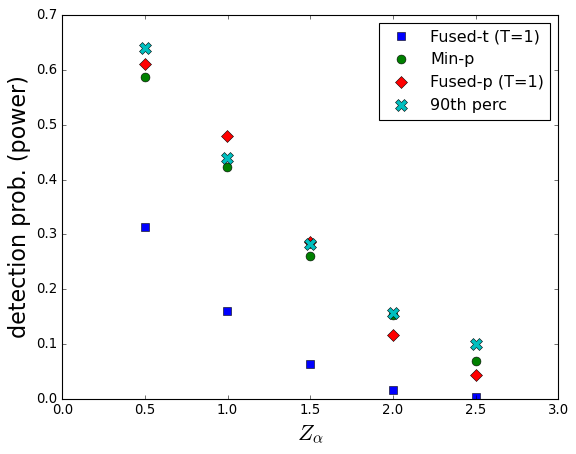

In [80]:
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fusion(ref,1),fusion(data,1))[1],label='Fused-t (T=1)',linestyle='None',marker='s',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(pmin_ref,pmin_data)[1],label='Min-p',linestyle='None',marker='o',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fused_p_ref,fused_p_data)[1],label='Fused-p (T=1)',linestyle='None',marker='D',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,-2],data[:,-2])[1],label='90th perc',linestyle='None',marker='X',ms=10)
plt.legend(numpoints=1)
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel('detection prob. (power)', fontsize=20)
plt.show()

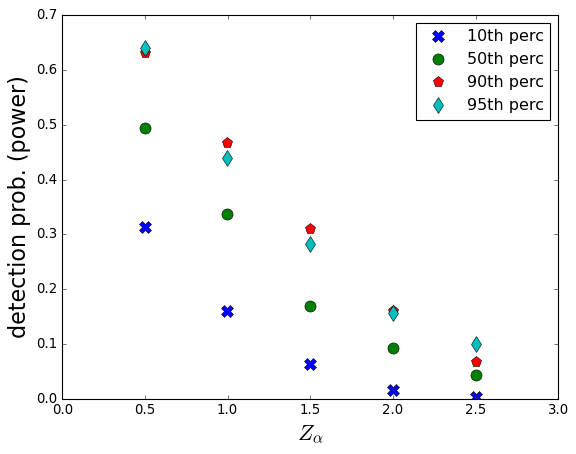

In [81]:
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,0],data[:,0])[1],label='10th perc',linestyle='None',marker='X',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,1],data[:,1])[1],label='50th perc',linestyle='None',marker='o',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,2],data[:,2])[1],label='90th perc',linestyle='None',marker='p',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,3],data[:,3])[1],label='95th perc',linestyle='None',marker='d',ms=10)
plt.legend(numpoints=1)
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel('detection prob. (power)', fontsize=20)
plt.show()

## nplm-avg

In [82]:
ref_avg = np.load(ref_folder+"/t_avg_array.npy")
data_avg = np.load(data_folder+"/t_avg_array.npy")

ref_avg_exp = np.load(ref_folder+"/t_avg_exp_array.npy")
data_avg_exp = np.load(data_folder+"/t_avg_exp_array.npy")

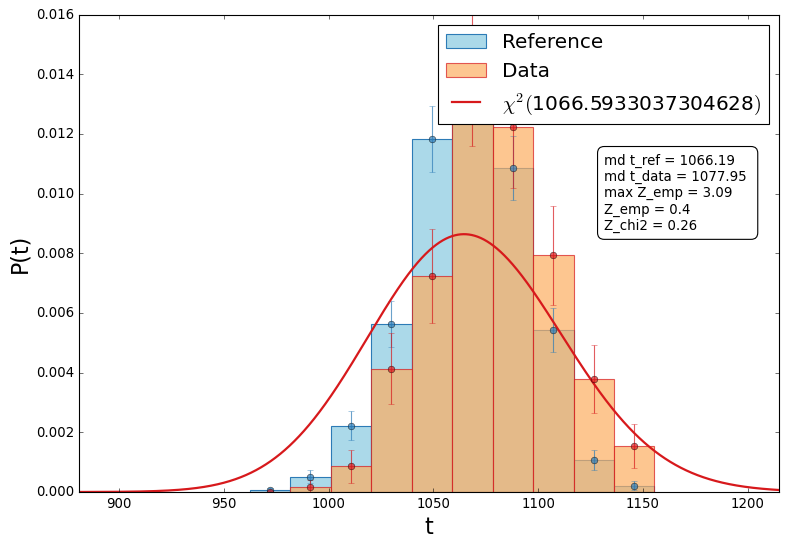

In [83]:
plot_ref_data(ref_avg,data_avg,dof=return_best_chi2dof(ref_avg)[0])

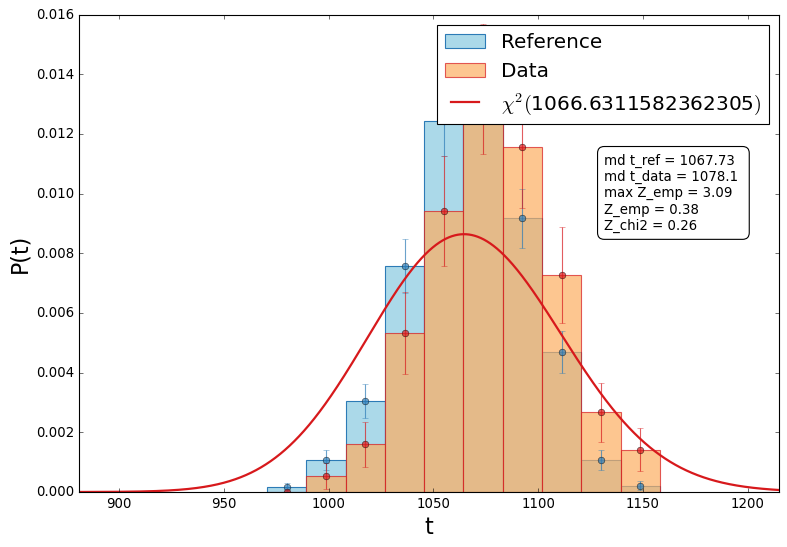

In [84]:
plot_ref_data(ref_avg_exp,data_avg_exp,dof=return_best_chi2dof(ref_avg_exp[:50000])[0])

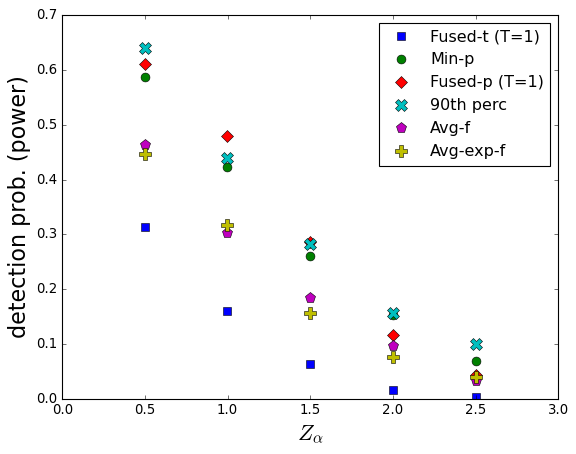

In [85]:
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fusion(ref,1),fusion(data,1))[1],label='Fused-t (T=1)',linestyle='None',marker='s',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(pmin_ref,pmin_data)[1],label='Min-p',linestyle='None',marker='o',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fused_p_ref,fused_p_data)[1],label='Fused-p (T=1)',linestyle='None',marker='D',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,-2],data[:,-2])[1],label='90th perc',linestyle='None',marker='X',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref_avg,data_avg)[1],label='Avg-f',linestyle='None',marker='p',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref_avg_exp,data_avg_exp)[1],label='Avg-exp-f',linestyle='None',marker='P',ms=10)
plt.legend(numpoints=1)
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel('detection prob. (power)', fontsize=20)
plt.show()

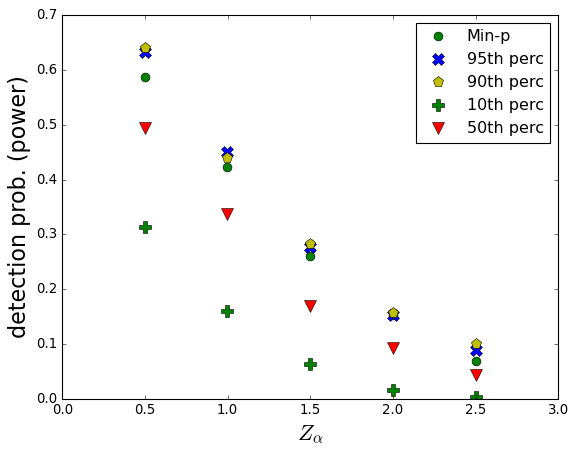

In [86]:
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(pmin_ref,pmin_data)[1],label='Min-p',linestyle='None',marker='o',ms=8, color='g')
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,-1],data[:,-1])[1],label='95th perc',linestyle='None',marker='X',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,-2],data[:,-2])[1],label='90th perc',linestyle='None',marker='p',ms=10,c='y')
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,0],data[:,0])[1],label='10th perc',linestyle='None',marker='P',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,1],data[:,1])[1],label='50th perc',linestyle='None',marker='v',ms=10)
plt.legend(numpoints=1)
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel('detection prob. (power)', fontsize=20)
plt.show()

## tests

In [ ]:
ref_old = np.load("./output_5d/Ntoys1000_NR100000_NB20000_cut60_null/t_array.npy")
ref_new = np.load("./backup/output_5d/Ntoys1000_NR100000_NB20000_cut60_null/t_array.npy")

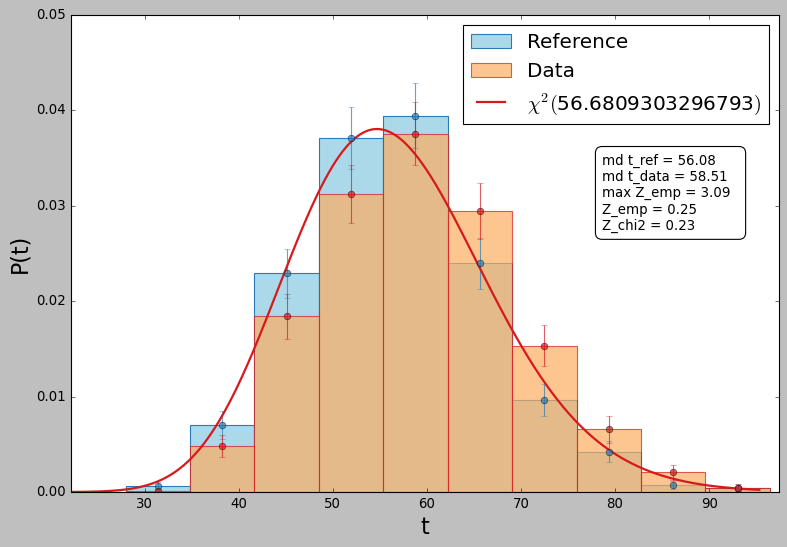

In [7]:
plot_ref_data(ref_old[:,2],ref_new[:,2],dof=return_best_chi2dof(ref_old[:,2])[0])

In [2]:
from FLKutils_min import BuildSample_DY

In [5]:
cut_mll = 60
cut_pt = 20
cut_eta = 2.4

In [16]:
def BuildSample_DY_2(INPUT_PATH, seed, features=[], N_Events=-1, nfiles=20, shuffle=True):
    np.random.seed(seed)
    #random integer to select Zprime file between n files                                                                                                            
    u = np.arange(nfiles)#np.random.randint(100, size=100)                                                                                                           
    if shuffle: np.random.shuffle(u)
    toy_label = INPUT_PATH.split("/")[-2]
    print(toy_label)
    HLF = np.array([])
    for u_i in u:
        if not os.path.exists(INPUT_PATH+toy_label+str(u_i+1)+".h5"): continue
        f    = h5py.File(INPUT_PATH+toy_label+str(u_i+1)+".h5", 'r')
        keys = list(f.keys())
        if u_i==u[0]:
            print('available features: ', keys)
        if len(keys)==0: continue #check whether the file is empty                                                                                                   
        cols = np.array([])
        if len(features): keys = features
        for i in range(len(keys)):
            feature = np.array(f.get(keys[i]))
            feature = np.expand_dims(feature, axis=1)
            if i==0: cols = feature
            else: cols = np.concatenate((cols, feature), axis=1)
        if shuffle: np.random.shuffle(cols) #don't want to select always the same event first                                                                       \
                                                                                                                                                                     
        if HLF.shape[0]==0:
            HLF=cols
            i+=1
        else: HLF=np.concatenate((HLF, cols), axis=0)
        f.close()
        if N_Events>0 and HLF.shape[0]>=N_Events:
            HLF=HLF[:N_Events, : ]
            break
    print(HLF.shape)
    #return HLF[:, [4, 5, 1, 2, 0, 3]]                                                                                                                               
    return HLF

In [3]:
#['delta_phi', 'eta1', 'eta2', 'mll', 'pt1', 'pt2'] how features are returned when loaded

from FLKutils_min import BuildSample_DY
reference = BuildSample_DY(N_Events=3735456, INPUT_PATH='/data/marcol/HEPDATA/DILEPTON/DiLepton_SM/', rng=np.random.default_rng(seed=1234))
#reference = BuildSample_DY_2('/data/marcol/HEPDATA/DILEPTON/DiLepton_SM/', 1234, features=['delta_phi', 'eta1', 'eta2', 'mll', 'pt1', 'pt2'], N_Events=-1, nfiles=66, shuffle=True)

DiLepton_SM
(3735456, 6)


In [6]:
mask_idx = np.where((reference[:, 4] <= cut_pt) | (reference[:, 5] <= cut_pt) | (np.abs(reference[:, 1]) > cut_eta) | (np.abs(reference[:, 2]) > cut_eta) | (reference[:, 3] <= cut_mll))[0]
masked_ref = np.delete(reference, mask_idx, axis=0)
#mask = 1*(reference[:,3]>=cut_mll)*(np.abs(reference[:,1])<cut_eta)*(np.abs(reference[:,2])<cut_eta)*(reference[:,4]>=cut_pt)*(reference[:,5]>=cut_pt)
#masked_ref = reference[mask>0]

In [7]:
#masked_ref = masked_ref[:,]
mean_R = np.mean(masked_ref, axis=0)
std_R  = np.std(masked_ref, axis=0)

In [8]:
mean_R

array([3.05212537e+00, 4.59876795e-04, 3.66978211e-04, 9.11198636e+01,
       4.67488118e+01, 3.60544255e+01])

In [44]:
std_R


array([ 0.52342366,  1.24487457,  1.25051629, 15.86122412,  8.95046637])

In [33]:
np.mean(masked_ref[:,1])

0.0004598767946975146

In [21]:
np.mean(masked_ref[:,3])

91.11986355771019